IMPORTING PACKAGES

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
from sklearn import model_selection, metrics

if not sys.warnoptions:
    warnings.simplefilter("ignore")

LOADING TEST TRAIN DATA

In [7]:
train=pd.read_csv("train.csv",na_values={"Item_Visibility":[0]})

test=pd.read_csv("test.csv",na_values={"Item_Visibility":[0]})


train['source']='train'

test['source']='test'

data=pd.concat([train,test],ignore_index=True)

discpt=data.describe()

nan_descript=data.apply(lambda x: sum(x.isnull()))

uniq=data.apply(lambda x: len(x.unique()))

col=["Item_Fat_Content","Item_Type","Outlet_Location_Type","Outlet_Size"]

for i in col:
    print("\n\nThe frequency distribution of each catogorical columns is--" + i+"\n")
    print(data[i].value_counts())   



The frequency distribution of each catogorical columns is--Item_Fat_Content

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


The frequency distribution of each catogorical columns is--Item_Type

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64


The frequency distribution of each catogorical columns is--Outlet_Location_Type

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64


The frequency distribution of each catogorical colu

DATA PROCESSING

In [8]:
data.fillna({"Item_Weight":data["Item_Weight"].mean()},inplace=True)

nan_descript=data.apply(lambda x: sum(x.isnull()))

data["Outlet_Size"].fillna(method="ffill",inplace=True)

nan_descript=data.apply(lambda x: sum(x.isnull()))

visibilty_avg=data.pivot_table(values="Item_Visibility",index="Item_Identifier")

itm_visi=data.groupby('Item_Type')

data_frames=[]
for item,item_df in itm_visi:
    data_frames.append(itm_visi.get_group(item))
for i in data_frames:
    i["Item_Visibility"].fillna(value=i["Item_Visibility"].mean(),inplace=True)
    i["Item_Outlet_Sales"].fillna(value=i["Item_Outlet_Sales"].mean(),inplace=True)

new_data=pd.concat(data_frames)

nan_descript=new_data.apply(lambda x: sum(x.isnull()))

new_data["Item_Fat_Content"].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)

new_data["Item_Fat_Content"].value_counts()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data=new_data
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type','Outlet_Type']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type'])

train = data.loc[data['source']=="train"]

test = data.loc[data['source']=="test"]

test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)

train.drop(['source'],axis=1,inplace=True)

train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

mean_sales = train['Item_Outlet_Sales'].mean()

base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

base1.to_csv("alg0.csv",index=False)


target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

MODEL CREATION OF LINEAR REGRESSION , RIDGE REGRESSION , DECISION TREE REGRESSOR AND RANDOM FOREST AND CALCULATING RMSE

Creating the models and processing



Model Report by Linear Regression:

Root Mean Square Error : 1128


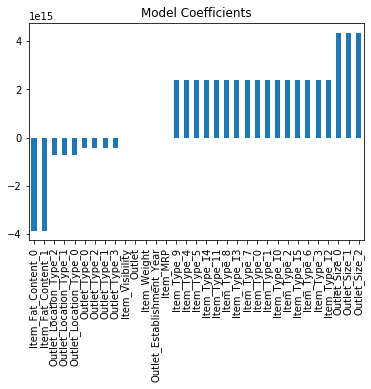


Model Report by Ridge Regression:

Root Mean Square Error : 1130


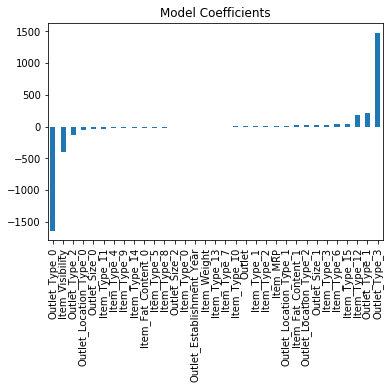

Model has been successfully created and trained. The predicted result is in alg2.csv

Model Report by Decision Tree:

Root Mean Square Error : 1059


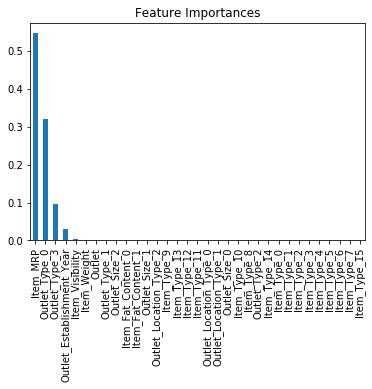

Model has been successfully created and trained. The predicted result is in alg3.csv

Model Report by Random Forest with MAX DEPTH=5:

Root Mean Square Error : 1073


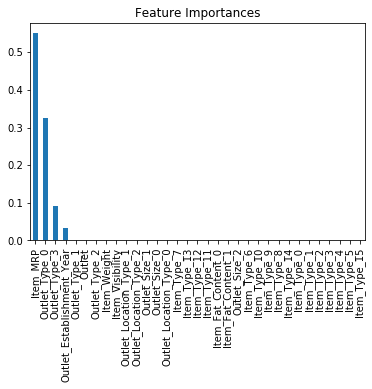

Model has been successfully created and trained. The predicted result is in alg5.csv

Model Report by Random Forest with MAX DEPTH=6:

Root Mean Square Error : 1068


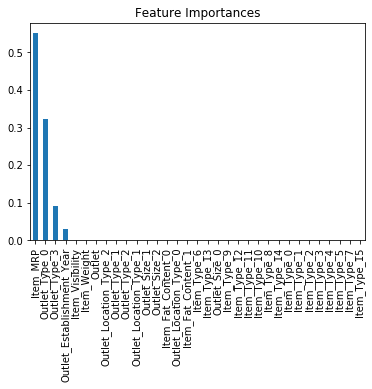

Model has been successfully created and trained. The predicted result is in alg6.csv


In [9]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])
    print ("Root Mean Square Error : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    dtest[target] = alg.predict(dtest[predictors])
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)
    
print("Creating the models and processing\n\n")

from sklearn.linear_model import LinearRegression, Ridge
print ("\nModel Report by Linear Regression:\n")
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')
plt.show()

print ("\nModel Report by Ridge Regression:\n")
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')
plt.show()
print("Model has been successfully created and trained. The predicted result is in alg2.csv")

print ("\nModel Report by Decision Tree:\n")
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')
plt.show()
print("Model has been successfully created and trained. The predicted result is in alg3.csv")

print ("\nModel Report by Random Forest with MAX DEPTH=5:\n")
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')
plt.show()
print("Model has been successfully created and trained. The predicted result is in alg5.csv")

print ("\nModel Report by Random Forest with MAX DEPTH=6:\n")
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')
plt.show()
print("Model has been successfully created and trained. The predicted result is in alg6.csv")